In [307]:
%load_ext autoreload
%autoreload

from retro_branching.utils import get_most_recent_checkpoint_foldername, PlotAesthetics

import glob
import gzip
import pickle
from collections import defaultdict
import copy
import numpy as np
import scipy.stats as st
import math
from ordered_set import OrderedSet
import time
from sqlitedict import SqliteDict
import os

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
pd.set_option("display.max_rows", 100, "display.max_columns", None)
from tabulate import tabulate
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
# # 500x1000 Etheve et al. baseline
# agent_to_path = {
#                  'PB': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_gasse_2019/baselines/pseudocost/rl_validator/rl_validator_1/',
#                  'SB': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_gasse_2019/baselines/strong_branching/rl_validator/rl_validator_1/',
#                  'IL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_gasse_2019/baselines/gnn_361_checkpoint_139/rl_validator/rl_validator_1/',
# #                  'Step-Orig': <path>,
# #                  'Etheve': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_gasse_2019/baselines/dqn_gnn_1484_checkpoint_79/rl_validator/rl_validator_1/',
#                  'Step-Retro': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_gasse_2019/baselines/dqn_gnn_1481_checkpoint_79/rl_validator/rl_validator_1/',
# #                  'MAB-Retro': <path>,
#                 }

# # 500x1000 set covering baseline comparison
# agent_to_path = {
# #                  'PB': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_gasse_2019/baselines/pseudocost/rl_validator/rl_validator_1/',
# #                  'SB': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_gasse_2019/baselines/strong_branching/rl_validator/rl_validator_1/',
# #                  'IL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_gasse_2019/baselines/gnn_361_checkpoint_139/rl_validator/rl_validator_1/',
#                  'Retro': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1481/',
#                  'Original': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1405/',
#                  'FMSTS': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1484/',
# #                  'MAB-Retro': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1485/',
# #                  'NLPG-Retro': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1487/',
#                 }

# # 500x1000 different sub-tree construction heuristics
# agent_to_path = {
#                  'MLPG': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1481/',
#                  'R': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1488/',
#                  'VO': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1489/',
#                  'D': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1490/',
#                 }

# # 500x1000 set covering
agent_to_path = {
                 'Retro': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1481/'
                }

# # # 165x230 set covering
# agent_to_path = {
#                  'Retro': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1491/'
#                 }


metrics = ['num_nodes', 'lp_iterations']
metric_to_label = {'num_nodes': 'Nodes', 'lp_iterations': 'LP Iterations'}

In [319]:
# load agent logs
episodes_logs_dict, epochs_logs_dict = {}, {}
validation_dict = defaultdict(list)
agent_name_to_display_name = {}
for display_name, agent_path in agent_to_path.items():
    if agent_path[-1] != '/':
        raise Exception(f'Agent path {agent_path} must end with /')
    orig_agent_name = agent_path.split('/')[-2]
    print(f'\nLoading logs for {display_name} agent from {agent_path}...')
    
    # load epochs log
    start_t = time.time()
    epochs_logs_dict[display_name] = {}
    start_t = time.time()
    with SqliteDict(agent_path+'/database/epochs_log.sqlite') as log:
        for key, val in log.items():
            # read into memory
            epochs_logs_dict[display_name][key] = val
        log.close()
    print(f'Loaded epoch data in {time.time() - start_t:.3f} s.')
    
    # get total epochs ran for this agent
    total_epochs = epochs_logs_dict[display_name]['num_epochs'][-1]
    
    # get paths to saved agent checkpoints
    checkpoint_paths = sorted(glob.glob(agent_path+'/checkpoint_*'))
    checkpoints = [int(path.split('/')[-1].split('_')[-1]) for path in checkpoint_paths]
    
    # calc checkpoint frequency (-1 to account for checkpoint saved at epoch 0)
    checkpoint_freq = int(total_epochs / (len(checkpoints) - 1))
    print(f'Number of epochs: {total_epochs} | Number of checkpoints: {len(checkpoints)} | Checkpoint frequency: {checkpoint_freq}')
    
    # load validation data at each checkpoint
    for checkpoint in sorted(checkpoints):
        checkpoint_path = agent_path + f'/checkpoint_{checkpoint}'
        validator_path = checkpoint_path + '/rl_validator/rl_validator_1/'
        if os.path.isdir(validator_path):
            print(f'{display_name} {checkpoint_path.split("/")[-1]} has validator data, loading...')
            start_t = time.time()
            
            cp = get_most_recent_checkpoint_foldername(validator_path, idx=-1)
            validator_path += f'{cp}/'
            with gzip.open(*glob.glob(validator_path+'*log.pkl'), 'rb') as f:
                validation_log = pickle.load(f)

            for metric in metrics:
                # metrics are stored as per episode step reward, so total metric is sum of reward at each step
                validation_dict[metric] += [abs(np.sum(rewards)) for rewards in validation_log[orig_agent_name][metric]]
            for _ in range(len(validation_log[orig_agent_name][metric])):
                # add agent name and epoch for each episode
                validation_dict['Agent'].append(display_name)
                validation_dict['num_epochs'].append(int((checkpoint-1)*checkpoint_freq))
                validation_dict['Checkpoints'].append(checkpoint)
            
            print(f'Loaded validator data in {time.time() - start_t:.3f} s.')
            
        else:
            print(f'{display_name} {checkpoint_path.split("/")[-1]} has no validation data, skipping...')
            
            
    print(f'Loaded {display_name} agent epochs log in {time.time() - start_t:.3f} s')
print(f'\nAll agent logs loaded.')

df = pd.DataFrame(validation_dict)
display(df)


Loading logs for Retro agent from /scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1481/...
Loaded epoch data in 5.408 s.
Number of epochs: 487500 | Number of checkpoints: 195 | Checkpoint frequency: 2512
Retro checkpoint_1 has no validation data, skipping...
Retro checkpoint_2 has no validation data, skipping...
Retro checkpoint_3 has no validation data, skipping...
Retro checkpoint_4 has no validation data, skipping...
Retro checkpoint_5 has validator data, loading...
Loaded validator data in 0.043 s.
Retro checkpoint_6 has validator data, loading...
Loaded validator data in 0.030 s.
Retro checkpoint_7 has validator data, loading...
Loaded validator data in 0.028 s.
Retro checkpoint_8 has validator data, loading...
Loaded validator data in 0.032 s.
Retro checkpoint_9 has validator data, loading...
Loaded validator data in 0.021 s.
Retro checkpoint_10 has validator data, loading...
Loaded validator data in 0.028 s.
Retro checkpoint_11 has validator data, loading...
Loade

Loaded validator data in 0.005 s.
Retro checkpoint_124 has validator data, loading...
Loaded validator data in 0.005 s.
Retro checkpoint_125 has validator data, loading...
Loaded validator data in 0.004 s.
Retro checkpoint_126 has validator data, loading...
Loaded validator data in 0.004 s.
Retro checkpoint_127 has validator data, loading...
Loaded validator data in 0.005 s.
Retro checkpoint_128 has validator data, loading...
Loaded validator data in 0.005 s.
Retro checkpoint_129 has validator data, loading...
Loaded validator data in 0.004 s.
Retro checkpoint_130 has validator data, loading...
Loaded validator data in 0.005 s.
Retro checkpoint_131 has validator data, loading...
Loaded validator data in 0.004 s.
Retro checkpoint_132 has validator data, loading...
Loaded validator data in 0.004 s.
Retro checkpoint_133 has validator data, loading...
Loaded validator data in 0.004 s.
Retro checkpoint_134 has validator data, loading...
Loaded validator data in 0.005 s.
Retro checkpoint_135

,num_nodes,lp_iterations,Agent,num_epochs,Checkpoints
0,482.0,24670.0,Retro,10048,5
1,66.0,4231.0,Retro,10048,5
2,66.0,1557.0,Retro,10048,5
3,1004.0,35629.0,Retro,10048,5
4,32.0,526.0,Retro,10048,5
...,...,...,...,...,...
18895,24.0,1384.0,Retro,482304,193
18896,26.0,962.0,Retro,482304,193
18897,12.0,709.0,Retro,482304,193
18898,32.0,1149.0,Retro,482304,193


In [320]:
xaxis = 'num_epochs' # Epochs

rolling_window = None
# rolling_window = int(5)
# rolling_window = int(10)
# rolling_window = int(50)
# rolling_window = int(100)
# rolling_window = int(150)
# rolling_window = int(300)
# rolling_window = int(500) # paper training curve
# rolling_window = int(1e3)
# rolling_window = int(2e3)
# rolling_window = int(10e3)

xlog = False # False True
ylog = True # False True

xaxis_label_style = 'sci' # paper training curve
yaxis_label_style = 'plain'

xlim = None
# xlim = [0, 2e5] # paper training curve
# xlim = [0, 1.3e5]
# xlim = [0, 1.5e5]
# xlim = [0, 2e5]
# xlim = [0, 2.1e5]
# xlim = [0.15e5, None]
ylim = None

# legend = False # 'auto' False
legend = 'auto'
legend_font_size = 7.5 # same as default latex font#
# legend_font_size = 5 # smaller
# n_rows = 1
n_rows = 2

scaling_factor = 0.6 # paper training curve
# scaling_factor = 2.5
# scaling_factor = 0.4
width_scaling_factor = 1
height_scaling_factor = 1

aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve
# aesthetics.set_icml_paper_plot_aesthetics(font_scale=0.4, linewidth=0.4)

In [321]:
# calc rolling averages
_new_df = copy.deepcopy(df)
if rolling_window is not None:
    for param in ['num_nodes', 'lp_iterations']:
#         new_df[param] = _new_df[param].rolling(rolling_window, center=False).mean()
#         new_df[param] = _new_df[param].rolling(rolling_window, center=False).mean().fillna(method='bfill').fillna(method='ffill')
#         new_df[param] = _new_df[param].rolling(rolling_window, center=False).mean()
        new_df[param] = _new_df.groupby('Agent').rolling(rolling_window, center=False)[param].mean()
    print(f'\nNew DF after applying rolling average:')
    display(new_df[:15])
    display(new_df)
    display(new_df[-15:])
else:
    new_df = copy.deepcopy(df)

# xaxis = 'num_episodes' # TEMPORARY
if xaxis == 'num_epochs':
    xlabel = 'Epochs'
    
display(new_df)

,num_nodes,lp_iterations,Agent,num_epochs,Checkpoints
0,482.0,24670.0,Retro,10048,5
1,66.0,4231.0,Retro,10048,5
2,66.0,1557.0,Retro,10048,5
3,1004.0,35629.0,Retro,10048,5
4,32.0,526.0,Retro,10048,5
...,...,...,...,...,...
18895,24.0,1384.0,Retro,482304,193
18896,26.0,962.0,Retro,482304,193
18897,12.0,709.0,Retro,482304,193
18898,32.0,1149.0,Retro,482304,193


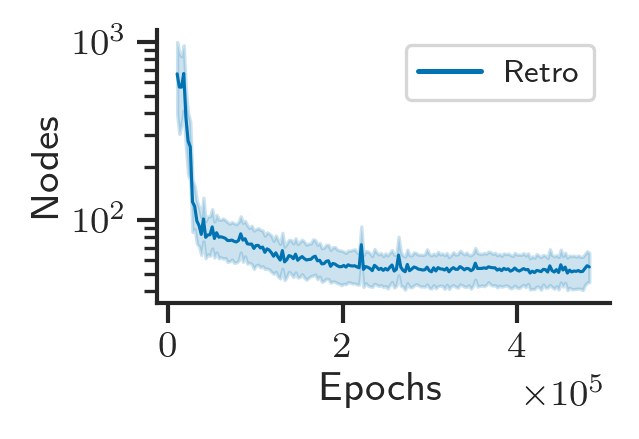

,Agent,Min num_nodes val,Min num_nodes epoch,Min num_nodes checkpoint,Max num_nodes val,Max num_nodes epoch,Max num_nodes checkpoint
0,Retro,50.47,457184,183,667.07,17584,8


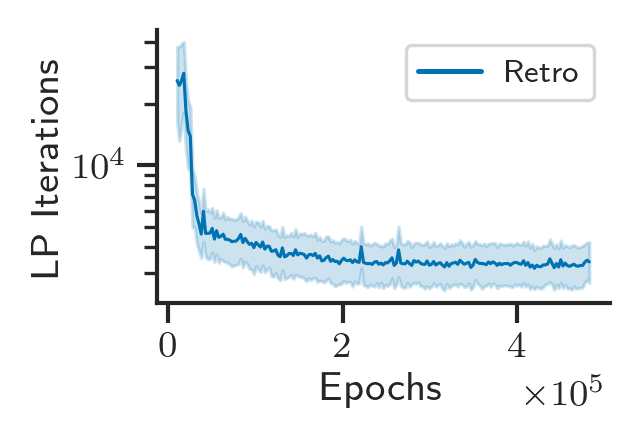

,Agent,Min lp_iterations val,Min lp_iterations epoch,Min lp_iterations checkpoint,Max lp_iterations val,Max lp_iterations epoch,Max lp_iterations checkpoint
0,Retro,3153.35,419504,168,28125.46,17584,8


In [322]:
for metric in metrics:
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.lineplot(data=new_df, x=xaxis, y=metric, hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
    if xlim is not None:
        plt.xlim(left=xlim[0], right=xlim[1])
    if ylim is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])
    # plt.legend(loc='upper right')
    # ax.legend(loc='lower left', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=2, prop={'size': 3})
    ax.legend(
#               loc='upper center',
#               loc='upper left',
              loc='best',
#               bbox_to_anchor=(0.5, 1.2), 
#               bbox_to_anchor=(0.5, 1.2),
              labelspacing=0.1,
              columnspacing=0.2,
              ncol=int(len(list(agent_to_path.keys()))/n_rows), 
              prop={'size': legend_font_size})
    g.set_xlabel(xlabel)
    g.set_ylabel(metric_to_label[metric])
    plt.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
    plt.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    if xlog:
        g.set(xscale='log')
    if ylog:
        g.set(yscale='log')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()
    
    
    # calc min-max vals and display in table with corresponding epoch and checkpoint
    summary_dict = defaultdict(list)
#     grouped_df = new_df.groupby(['Agent', 'num_epochs'])[metric].apply(list).to_dict()
    grouped_df = new_df.groupby(['Agent', 'num_epochs'])[metric].mean()
#     display(grouped_df)
    grouped_metric_df = grouped_df.groupby('Agent').apply(list).to_dict()
#     display(grouped_metric_df)
    
    grouped_df = new_df.groupby(['Agent', 'num_epochs'])['num_epochs'].mean()
#     display(grouped_df)
    grouped_epoch_df = grouped_df.groupby('Agent').apply(list).to_dict()
#     display(grouped_epoch_df)    
    
    grouped_df = new_df.groupby(['Agent', 'num_epochs'])['Checkpoints'].mean()
#     display(grouped_df)
    grouped_checkpoint_df = grouped_df.groupby('Agent').apply(list).to_dict()
#     display(grouped_checkpoint_df)
    
    for agent in agent_to_path:
        summary_dict['Agent'].append(agent)
        
        min_idx = np.argmin(grouped_metric_df[agent])
        min_val = grouped_metric_df[agent][min_idx]
        min_epoch = grouped_epoch_df[agent][min_idx]
        min_checkpoint = grouped_checkpoint_df[agent][min_idx]
        summary_dict[f'Min {metric} val'].append(min_val)
        summary_dict[f'Min {metric} epoch'].append(min_epoch)
        summary_dict[f'Min {metric} checkpoint'].append(min_checkpoint)
        
        max_idx = np.argmax(grouped_metric_df[agent])
        max_val = grouped_metric_df[agent][max_idx]
        max_epoch = grouped_epoch_df[agent][max_idx]
        max_checkpoint = grouped_checkpoint_df[agent][max_idx]
        summary_dict[f'Max {metric} val'].append(max_val)
        summary_dict[f'Max {metric} epoch'].append(max_epoch)
        summary_dict[f'Max {metric} checkpoint'].append(max_checkpoint)
        
        
    display(pd.DataFrame(summary_dict))
    